In [1]:
import os
import time
import numpy as np

from PIL import Image
from IPython import display
from IPython.display import Video
import matplotlib.pyplot as plt
import seaborn as sns
import moviepy.editor as mpy
from base64 import b64encode

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import resize

import wandb

In [2]:
wandb.login()

wandb: Currently logged in as: parameterized. Use `wandb login --relogin` to force relogin


True

In [3]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['image.cmap'] = 'binary'
sns.set_theme(style='darkgrid')

def display_video(path, loop=True):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display.display(display.HTML(f'''<video src="{
        data_url}" controls=true autoplay=true {
        "loop=true " if loop else ""}/>'''))

eps = 1e-5
device = 'cuda'

In [4]:
# todo: compute actual mean/std
data_mean = np.full(3, .5)
data_std = np.full(3, .25)
print(data_mean, data_std)

# norm and inverse norm transformations
norm_t = transforms.Normalize(data_mean, data_std)
invnorm_t = transforms.Normalize(-data_mean / data_std, 1 / data_std)

tensor_to_img = lambda x: invnorm_t(x).clip(0, 1).movedim(-3, -1).detach().cpu()

[0.5 0.5 0.5] [0.25 0.25 0.25]


In [5]:
frames_path = 'datasets/jams-germs/frames/Earthworm Under Microscope'
frame_count = len(os.listdir(frames_path))
frame_area = 910 * 512

n_frames = 8

def sample_video_patches(batch_size=32, patch_size=32, scale=(1, 1), n_frames=n_frames):
    ps = patch_size
    area = ps**2 / frame_area
    rrc = transforms.RandomResizedCrop((ps, ps),
        scale=(area * scale[0], area * scale[1]), ratio=(1, 1))
    rrc = transforms.Compose([transforms.ToTensor(), rrc])
    batch = torch.empty(batch_size, n_frames, 3, ps, ps)
    for i in range(batch_size):
        start_frame = np.random.randint(frame_count - n_frames + 1)
        for j in range(n_frames):
            img = Image.open(f'{frames_path}/{start_frame + j}.jpg')
            batch[i, j] = rrc(img)
    return batch

In [45]:
n_levels = 4
patch_size = 32

def get_batch(batch_size=32, patch_size=32, scale=(1, 1),
              n_levels=n_levels, n_frames=n_frames):
    x0s = []
    ps = patch_size
    for i in range(n_levels):
        x0s.append(torch.empty(batch_size, n_frames, 3, ps, ps, device=device))
        ps //= 2
    
    x0s[0] = norm_t(sample_video_patches(batch_size=batch_size, patch_size=patch_size,
                                         scale=scale, n_frames=n_frames)).to(device)
    for i in range(1, n_levels):
        # resize all frames by flattening onto batch dim
        x0_prev_timeflat = x0s[i - 1].view(-1, *x0s[i - 1].shape[-3:])
        x0s[i] = resize(x0_prev_timeflat, x0s[i].shape[-1]).view(x0s[i].shape)
    
    return x0s

embed_channels = 16 # divisible by 2

def embed_ts(t, n_freqs=embed_channels // 2):
    emb = t[..., None] * 2**torch.arange(n_freqs, device=device) * torch.pi / 2
    return torch.cat([emb.sin(), emb.cos()], dim=-1)

In [7]:
# (910*512)/(32*32) = 455 (full size patches)
def gen_trainset_video(path, fps=12):
    bx = get_batch(patch_size=32, scale=(455, 455))
    def make_frame(i_list):
        frame = torchvision.utils.make_grid(invnorm_t(bx[0][:16, i_list[0]]), nrow=4)
        i_list[0] = min(i_list[0] + 1, bx[0].shape[1] - 1)
        frame = resize(frame, 512).permute(1, 2, 0)
        return frame.clip(0, 1).multiply(255).int().cpu().numpy()
    
    os.makedirs(os.path.dirname(path), exist_ok=True)
    i_list = [0]
    clip = mpy.VideoClip(lambda t: make_frame(i_list), duration=n_frames/fps)
    clip.write_videofile(path, fps=fps)
    return clip

clip = gen_trainset_video('output/trainset_video.mp4')
display_video('output/trainset_video.mp4', loop=True)

Moviepy - Building video output/trainset_video.mp4.
Moviepy - Writing video output/trainset_video.mp4



Moviepy - Done !
Moviepy - video ready output/trainset_video.mp4


In [52]:
cell_channels = 32
hidden_feats = 128

class LayerNorm(nn.Module):
    def forward(self, x):
        var, mean = torch.var_mean(x, dim=1,
            unbiased=False, keepdim=True)
        return (x - mean) * (var + eps).rsqrt()

class FractalDN(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Conv2d((3 + cell_channels) * 3, hidden_feats, 3,
                            padding=1, padding_mode='replicate')
        self.l2 = nn.Conv2d(hidden_feats, 3 + cell_channels, 1)
        
        self.scale_shift_l1 = nn.Sequential(
            nn.SiLU(),
            nn.Linear(embed_channels * 2, hidden_feats * 2))
        self.scale_shift_l2 = nn.Sequential(
            nn.SiLU(),
            nn.Linear(embed_channels * 2, (3 + cell_channels) * 2))
        
        self.layer_norm = LayerNorm()
        
        nn.init.zeros_(self.l2.weight)
        nn.init.zeros_(self.l2.bias)
    
    def forward(self, bts, btes, bxts):
        """
        Evaluate the model
        
        Args:
            bts, btes, bxts: Lists of tensors
                with resolution decreasing by half (e.g. 32, 16, 8).
                bts - batch t tensors for frame pair
                btes - batch t embedding tensors for frame pair
                bxts - batch x_t tensors in the concatenated form
                [x_0 (this frame), x_0 (next frame), hidden channels]
        
        Returns:
            A list of concatenated predictions for
            [x_0 (this frame), x_0 (next frame), hidden channels]
        """
        preds = []
        # concat btes frames on channel dim
        btes = torch.cat([btes[:, 0], btes[:, 1]], dim=-1)
        ss_l1 = self.scale_shift_l1(btes)
        ss_l2 = self.scale_shift_l2(btes)
        for i, bxt in enumerate(bxts):
            # higher res, lower res
            hr = bxt if i == 0 else resize(bxts[i - 1], bxt.shape[-1])
            lr = bxt if i == len(bxts) - 1 else resize(
                bxts[i + 1], bxt.shape[-1])
            xin = torch.cat([hr, bxt, lr], dim=1)
            
            h = self.l1(xin).relu()
            h = self.layer_norm(h) * ss_l1[:, :hidden_feats, None, None]
            h = h + ss_l1[:, hidden_feats:, None, None]
            
            h = self.l2(h)
            h = self.layer_norm(h) * ss_l2[:, :(3 + cell_channels), None, None]
            py = h + ss_l2[:, (3 + cell_channels):, None, None]
            
            preds.append(bxt + py)
        
        return preds

model = FractalDN().cuda()

opt = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt,
    lambda epoch: max(0.95**epoch, 0.1))
loss_fn = nn.MSELoss()
losses = []

500 / 500
10m - eta 1s
lr: 0.00050000
loss: 0.12962439


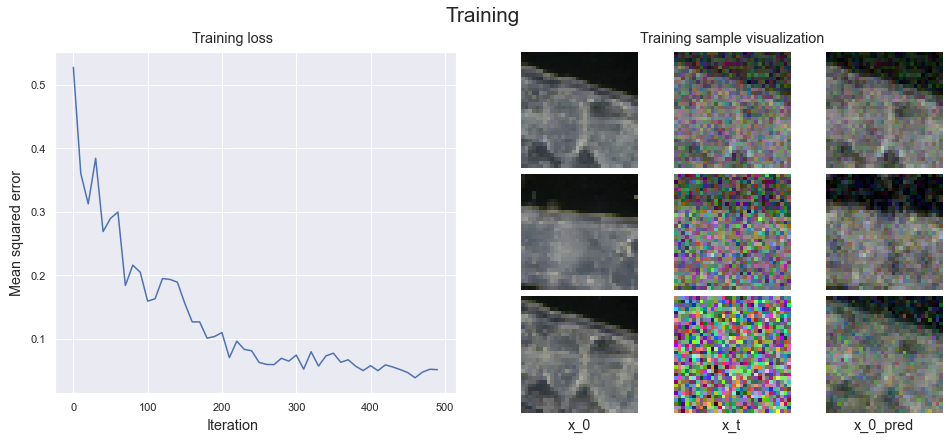

Saved to models/FractalDN_video_069010810.pt


In [53]:
model_id = f'{np.random.randint(1e9):09d}'

run = wandb.init(
    mode='disabled',
    project='FractalDN',
    config={
        'model_id': model_id,
        'cell_channels': cell_channels,
        'video': True
    },
    save_code=True)
wandb.define_metric('train/step')
wandb.define_metric('train/*', step_metric='train/step')

with run:
    print('Training...')
    train_st = time.time()
    time_to_s = lambda t: f'{int(t)}s' if t < 60 else f'{int(t / 60)}m'

    train_iters = int(5e2)
    batch_size = 16
    model_steps_per_frame = (2, 4) # min, max inclusive

    loss_every_n = 10
    display_every_n = 100
    scheduler_every_n = 500

    for i in range(train_iters):        
        bx0s = get_batch(batch_size=batch_size, n_frames=n_frames, scale=(455, 455))
        bts = torch.rand(batch_size, n_frames, device=device)
        btes = embed_ts(bts)
        bns = [torch.randn_like(bx0s[0])]
        ps = patch_size
        for j in range(1, n_levels):
            ps //= 2
            # resize all frames by flattening onto batch dim
            bn_prev_timeflat = bns[-1].view(-1, *bns[-1].shape[-3:])
            bns.append(resize(bn_prev_timeflat, ps).view(bx0s[j].shape))
        
        bxt_rgbs = [torch.lerp(bx0, bn, bts[..., None, None, None])
                   for bx0, bn in zip(bx0s, bns)]
        
        bxt_hiddens = [torch.randn(batch_size, cell_channels - 3, *x0.shape[-2:],
            device=device) for x0 in bx0s]
        
        # predict x_0
        loss = 0
        for frame_id in range(n_frames - 1):
            # randomize hiddens every frame
            bxt_hiddens = [torch.randn(batch_size, cell_channels - 3, *x0.shape[-2:],
                device=device) for x0 in bx0s]
            
            spf = np.random.randint(model_steps_per_frame[0], model_steps_per_frame[1] + 1)
            for _ in range(spf):
                bxts = [torch.cat([bxt_rgb[:, frame_id],
                                   bxt_rgb[:, frame_id + 1], bxt_hidden], dim=1)
                        for bxt_rgb, bxt_hidden in zip(bxt_rgbs, bxt_hiddens)]
                x0_preds = model(bts[:, frame_id:frame_id + 2],
                                 btes[:, frame_id:frame_id + 2], bxts)
                # only update hidden channels
                bxt_hiddens = [x0p[:, 6:] for x0p in x0_preds]
            target_rgbs = [torch.cat([bx0[:, frame_id], bx0[:, frame_id + 1]], dim=1)
                           for bx0 in bx0s]
            loss = loss + torch.cat([loss_fn(x0p[:, :6], target_rgb)[None]
                for x0p, target_rgb in zip(x0_preds, target_rgbs)], dim=0).mean()
        
        loss = loss / (n_frames - 1)
        
        # opt step
        opt.zero_grad()
        loss.backward()
        opt.step()

        # plot
        if (i + 1) % loss_every_n == 0:
            losses.append(loss.item())
            wandb.log({
                'train/step': i + 1,
                'train/loss': loss.item()
            })
        if (i + 1) % display_every_n == 0:
            display.clear_output(wait=True)
            print(f'{i + 1 :,} / {train_iters:,}')
            time_passed = time.time() - train_st
            eta = time_passed * (train_iters - i) / max(i, 1)
            print(f'{time_to_s(time_passed)} - eta {time_to_s(eta)}')
            print(f'lr: {opt.state_dict()["param_groups"][0]["lr"]:.8f}')
            print(f'loss: {np.mean(losses[-100:]):.8f}')

            fig = plt.figure(constrained_layout=True, figsize=(6 * 2.2, 6))
            fig.suptitle('Training', fontsize='xx-large')
            [loss_fig, vis_fig] = fig.subfigures(1, 2, wspace=.1)

            loss_fig.suptitle('Training loss')
            loss_fig.supxlabel('Iteration')
            loss_fig.supylabel('Mean squared error')

            vis_fig.suptitle('Training sample visualization')

            ax = loss_fig.gca()
            sns.lineplot(np.arange(len(losses)) * loss_every_n, losses, ax=ax)

            vis_col_figs = vis_fig.subfigures(1, 3)
            [x0_axes, xt_axes, x0p_axes] = [
                v.subplots(3, 1) for v in vis_col_figs]
            for f, label in zip(vis_col_figs, ['x_0', 'x_t', 'x_0_pred']):
                f.supxlabel(label)

            for k in range(3):
                # show random samples of low, mid, high ranges of t
                # (for 2nd to last frame self prediction)
                t_sort = torch.argsort(bts[:, -2])
                row_id = t_sort[np.random.randint(
                    t_sort.shape[0] // 3 * k,
                    t_sort.shape[0] // 3 * (k + 1))]
                x0_axes[k].imshow(tensor_to_img(bx0s[0][row_id, -2]))
                x0_axes[k].axis('off')
                xt_axes[k].imshow(tensor_to_img(bxts[0][row_id, :3]))
                xt_axes[k].axis('off')
                x0p_axes[k].imshow(tensor_to_img(x0_preds[0][row_id, :3]))
                x0p_axes[k].axis('off')

            plt.show()
        if (i + 1) % scheduler_every_n == 0:
            scheduler.step()
    
    model_path = f'models/FractalDN_video_{model_id}.pt'
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    torch.save(model, model_path)
    print(f'Saved to {model_path}')

In [61]:
from tqdm import tqdm
tqdm._instances.clear()

diffusion_steps = 8
vid_batch_size = 4
vid_patch_size = 32

def gen_video(path, duration=2, fps=24):
    def make_frame(frame_state):        
        with torch.no_grad():
            ps = vid_patch_size
            frame_imgs = torch.empty(4, 4, 3, ps, ps)
            
            if frame_state.get('bxt_rgbs') is None:
                first_frame = True
                bxt_rgbs = [torch.randn(vid_batch_size, 6, ps, ps, device=device)]
                bxt_hiddens = [torch.randn(vid_batch_size, cell_channels - 3, ps, ps, device=device)]
                for i in range(1, n_levels):
                    ps //= 2
                    bxt_rgbs.append(resize(bxt_rgbs[-1], ps))
                    bxt_hiddens.append(torch.randn(vid_batch_size, cell_channels - 3, ps, ps, device=device))
            else:
                first_frame = False
                bxt_rgbs = [torch.cat([
                    torch.lerp(bxt_rgb[:, 3:], torch.randn_like(bxt_rgb[:, 3:]), .7),
                    torch.randn_like(bxt_rgb[:, 3:])
                ], dim=1) for bxt_rgb in frame_state['bxt_rgbs'][:1]]
                # bxt_hiddens = frame_state['bxt_hiddens']
                # persistent hidden drives it to randomness
                bxt_hiddens = [torch.randn(vid_batch_size, cell_channels - 3, ps, ps, device=device)]
                for i in range(1, n_levels):
                    ps //= 2
                    bxt_hiddens.append(resize(bxt_hiddens[-1], ps))

            for i, t in enumerate(np.linspace(1, 0, diffusion_steps, endpoint=False)):
                bts = torch.full((vid_batch_size, 2), t, device=device)
                if not first_frame:
                    bts[:, 0] = .7
                btes = embed_ts(bts)
                
                for _ in range(model_steps_per_frame[1]): # do max steps
                    bxts = [torch.cat([bxt_rgb, bxt_hidden], dim=1)
                            for bxt_rgb, bxt_hidden in zip(bxt_rgbs, bxt_hiddens)]
                    x0_preds = model(bts, btes, bxts)
                    # only update hidden channels
                    bxt_hiddens = [x0p[:, 6:] for x0p in x0_preds]
                
                # reverse diffusion step
                lerp_t = (1 / diffusion_steps / (t + eps)).clip(0, 1)
                bxt_rgbs = [torch.lerp(bxt_rgb, x0p[:, :6], lerp_t)
                            for bxt_rgb, x0p in zip(bxt_rgbs, x0_preds)]
                
                if i % 2 == 1:
                    frame_imgs[:, i // 2] = invnorm_t(bxt_rgbs[0][:, 3:])
            
            frame_state['bxt_rgbs'] = bxt_rgbs
            frame_state['bxt_hiddens'] = bxt_hiddens
        
            #frame = torchvision.utils.make_grid(invnorm_t(bxt_rgbs[0][:, 3:]), nrow=round(vid_batch_size**.5))
            frame = torchvision.utils.make_grid(frame_imgs.view(-1, *frame_imgs.shape[2:]), nrow=4)
            frame = resize(frame, 512).permute(1, 2, 0)
            return frame.clip(0, 1).multiply(255).int().cpu().numpy()
    
    os.makedirs(os.path.dirname(path), exist_ok=True)
    frame_state = {}
    clip = mpy.VideoClip(lambda t: make_frame(frame_state), duration=duration)
    clip.write_videofile(path, fps=fps)
    return clip

clip = gen_video('output/fractal_dn_video.mp4')
display_video('output/fractal_dn_video.mp4', loop=False)

Moviepy - Building video output/fractal_dn_video.mp4.
Moviepy - Writing video output/fractal_dn_video.mp4



Moviepy - Done !
Moviepy - video ready output/fractal_dn_video.mp4


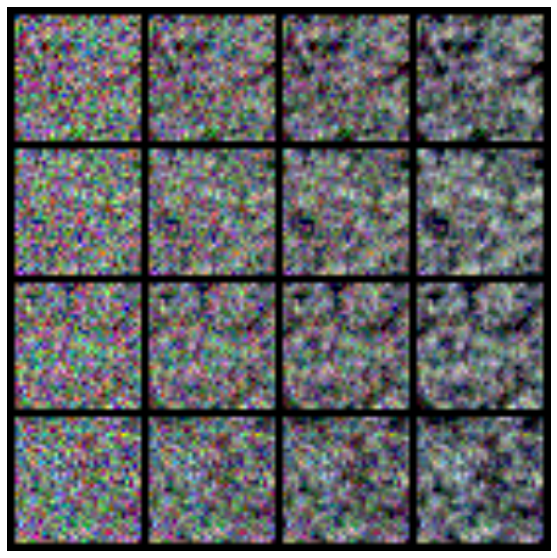

In [62]:
plt.figure(figsize=(10, 10))
plt.imshow(clip.get_frame(2) / 255)
plt.axis('off')
plt.show()